In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

data_path = './../../data/processed/'

import numpy as np

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
col = 'ID'
# df = pd.read_csv(data_path + col.replace(' ', '_')+'_Y.csv')
# df['date'] = pd.DatetimeIndex(pd.to_datetime(12*(df.YEAR - 1997) + df.MONTH, unit='M', origin=pd.Timestamp('1996-12-15'))).round('D')
# df.head()

In [3]:
df = pd.read_csv(data_path + 'ID_YQ.csv')

In [4]:
df.shape

(10309208, 5)

In [5]:
# May take a few seconds
df['Period'] = pd.to_datetime(df['YEAR'].astype(str) + '-Q'+ df['QUARTER'].astype(str))

### Yearly 

In [6]:
# there used to be groupby sum, but a set index should be correct
My = df.loc[df.IMPORT == 1].groupby(['ID', 'YEAR'])['VART'].sum().unstack()
Xy = df.loc[df.IMPORT == 0].groupby(['ID', 'YEAR'])['VART'].sum().unstack()

# sort by size
Xy = Xy.loc[Xy.sum(1).sort_values().index]
My = My.loc[My.sum(1).sort_values().index]

# logsales = np.log(cuadro) # LN

demlogXy = np.log10(Xy).subtract(np.log10(Xy).mean(1), axis = 0)
demlogMy = np.log10(My).subtract(np.log10(My).mean(1), axis = 0)

logdiffXy = np.log10(Xy).diff(axis = 1)
logdiffMy = np.log10(My).diff(axis = 1)

### Annual quarters

In [54]:
M_ = df.loc[df.IMPORT == 1].set_index(['ID', 'Period'])['VART'].unstack()
X_ = df.loc[df.IMPORT == 0].set_index(['ID', 'Period'])['VART'].unstack()

M = M_.fillna(0).rolling(4, axis = 1).sum()
X = X_.fillna(0).rolling(4, axis = 1).sum()

# sort by size
X = X.loc[X.sum(1).sort_values().index]
M = M.loc[M.sum(1).sort_values().index]

# logsales = np.log(cuadro) # LN

demlogX = np.log10(X).subtract(np.log10(X).mean(1), axis = 0)
demlogM = np.log10(M).subtract(np.log10(M).mean(1), axis = 0)

logdiffX = np.log10(X).diff(4, axis = 1)
logdiffM = np.log10(M).diff(4, axis = 1)

sizes_X = X.loc[X.sum(1).sort_values().index].sum(1)
sizes_M = M.loc[M.sum(1).sort_values().index].sum(1)

# For gross distinction of small, medium and large firms use quartiles.
parts_demo_x = pd.cut(sizes_X.cumsum()/sizes_X.sum(), 4, labels=range(4))#.sort_index()
parts_demo_m = pd.cut(sizes_M.cumsum()/sizes_M.sum(), 4, labels=range(4))#.sort_index()

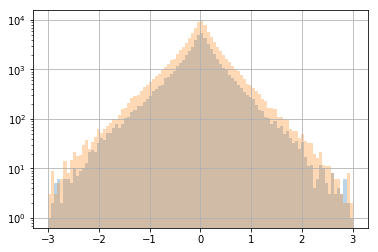

In [58]:
# # quiero chequear que logdiffX tomado cada 4 columnas sea lo mismo que logdiffXy

# # logdiffX.tail().T
# # logdiffXy.tail().T.head()
# # np.log10(Xy.tail().T.head())
# # np.log10(X.tail().T.head(15))


# # The values are identical for the last quarter, eg 1997-10-01

# # However the yearly numbers have nearly twice as many valid values. an average of 71000 per year, versus 32700 for the quarter series
# logdiffX.iloc[:, 3::4].count()
# logdiffXy.count()

# # This is possibly linked to distorted histogram
logdiffX.iloc[:, 3::4].stack().sample(100000).hist(bins = np.linspace(-3, 3, 101), alpha = .3)
logdiffXy.stack().sample(100000).hist(bins = np.linspace(-3, 3, 101), alpha = .3)
plt.yscale('log')

# Xy.loc[393341532]

## Paper figures for demeaned log shocks

### Separated by firm size (Small, medium, Large)
#### Quarter data

In [ ]:

# n = 3
fig, axs = plt.subplots(1, 3, figsize = (5*3, 3.5))

cut = 3

for j, label in enumerate(['Exports', 'Imports']):
    sales = [X, M][j]
    parts_demo = [parts_demo_x, parts_demo_m][j]
    demlogsales = [demlogX, demlogM][j]
    
    # Exports
    for i in range(3):
        size_mask = [parts_demo == 0, parts_demo == 1, parts_demo.isin([2, 3])][i]
        hist_bins = [100, 50, 50][i]
        ax = axs[i]
        ax.set_title(['Smallest firms holding 25% of value', 'Middle sized firms holding 25% of value', 'Largest firms holding 50% of value'][i])

#         log_rates = logsales.diff(axis = 1).stack()
        log_rates = demlogsales.loc[size_mask].stack()
        if len(log_rates) > 2e5: log_rates = log_rates.sample(int(5e5))
#         print(log_rates.shape)
        ax.hist(log_rates.loc[abs(log_rates) < cut], bins = hist_bins, alpha = .4)
        # wb_curve = ax.hist(log_rates.loc[abs(log_rates) < cut], bins = 150, alpha = .5)[0]
        ax.set_yscale('log')
        
        ### Measure of half nominal growth / Shrinkage.
        df_demlog_nominal = pd.concat([demlogsales.loc[size_mask].stack(), sales.subtract(np.power(10, np.log10(sales).mean(1)), axis = 0).loc[size_mask].stack()], axis = 1)
        df_demlog_nominal.columns = ['demlog', 'gap']

        df_demlog_nominal = df_demlog_nominal.sort_values('demlog')
        df_demlog_nominal_growth = df_demlog_nominal.loc[df_demlog_nominal.gap > 0]
        df_demlog_nominal_shrink = df_demlog_nominal.loc[df_demlog_nominal.gap <= 0]
        half_nominal_measure_r = df_demlog_nominal_growth.loc[df_demlog_nominal_growth['gap'].cumsum()/df_demlog_nominal_growth['gap'].sum() < .5].demlog.max()
        half_nominal_measure_l = df_demlog_nominal_shrink.loc[df_demlog_nominal_shrink['gap'].cumsum()/df_demlog_nominal_shrink['gap'].sum() < .5].demlog.max()

        ax.axvline(half_nominal_measure_r, c = '.5', linestyle = '--', lw = 1)
        ax.axvline(half_nominal_measure_l, c = '.5', linestyle = '--', lw = 1)
        
        ax.set_xlabel(r'$\log(S_{t}) - \log(\bar S)$', fontsize = 15)
        ax.set_ylabel('Frequency')

plt.savefig('./../../../WRITING/FIGURES/trade/fl_dist_YQ.png', bbox_inches = "tight")


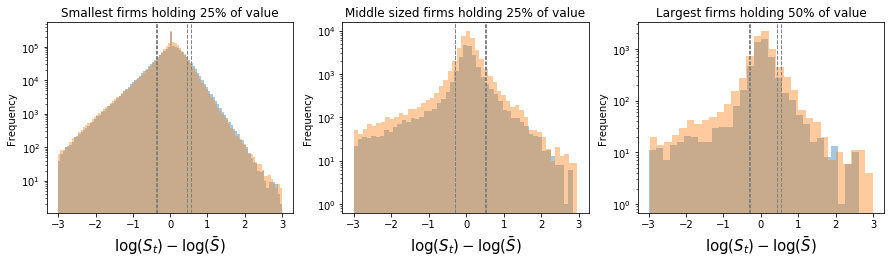

In [17]:

# n = 3
fig, axs = plt.subplots(1, 3, figsize = (5*3, 3.5))

cut = 3

for j, label in enumerate(['Exports', 'Imports']):
    sales = [Xy, My][j]                     ##### NOTE 'y'
    parts_demo = [parts_demo_x, parts_demo_m][j]
    demlogsales = [demlogXy, demlogMy][j]   ##### NOTE 'y'
    
    # Exports
    for i in range(3):
        size_mask = [parts_demo == 0, parts_demo == 1, parts_demo.isin([2, 3])][i]
        hist_bins = [100, 50, 30][i]
        ax = axs[i]
        ax.set_title(['Smallest firms holding 25% of value', 'Middle sized firms holding 25% of value', 'Largest firms holding 50% of value'][i])

    #     log_rates = logsales.diff(axis = 1).stack()
        log_rates = demlogsales.loc[size_mask].stack()
#         if len(log_rates) > 2e5: log_rates = log_rates.sample(int(5e5))
#         print(log_rates.shape)
        ax.hist(log_rates.loc[abs(log_rates) < cut], bins = hist_bins, alpha = .4)
        # wb_curve = ax.hist(log_rates.loc[abs(log_rates) < cut], bins = 150, alpha = .5)[0]
        ax.set_yscale('log')
        
        ### Measure of half nominal growth / Shrinkage.
        df_demlog_nominal = pd.concat([demlogsales.loc[size_mask].stack(), sales.subtract(np.power(10, np.log10(sales).mean(1)), axis = 0).loc[size_mask].stack()], axis = 1)
        df_demlog_nominal.columns = ['demlog', 'gap']

        df_demlog_nominal = df_demlog_nominal.sort_values('demlog')
        df_demlog_nominal_growth = df_demlog_nominal.loc[df_demlog_nominal.gap > 0]
        df_demlog_nominal_shrink = df_demlog_nominal.loc[df_demlog_nominal.gap <= 0]
        half_nominal_measure_r = df_demlog_nominal_growth.loc[df_demlog_nominal_growth['gap'].cumsum()/df_demlog_nominal_growth['gap'].sum() < .5].demlog.max()
        half_nominal_measure_l = df_demlog_nominal_shrink.loc[df_demlog_nominal_shrink['gap'].cumsum()/df_demlog_nominal_shrink['gap'].sum() < .5].demlog.max()

        ax.axvline(half_nominal_measure_r, c = '.5', linestyle = '--', lw = 1)
        ax.axvline(half_nominal_measure_l, c = '.5', linestyle = '--', lw = 1)
        
        ax.set_xlabel(r'$\log(S_{t}) - \log(\bar S) \equiv F_t$', fontsize = 15)
        ax.set_ylabel('Frequency')

plt.savefig('./../../../WRITING/FIGURES/trade/fl_dist_Y.png', bbox_inches = "tight")


In [ ]:
# n = 3
fig, axs = plt.subplots(1, 3, figsize = (5*3, 3.5))

cut = 3

for j, label in enumerate(['Exports', 'Imports']):
    sales = [X, M][j]
    parts_demo = [parts_demo_x, parts_demo_m][j]
    difflogsales = [logdiffX, logdiffM][j]
    
    # Exports
    for i in range(3):
        size_mask = [parts_demo == 0, parts_demo == 1, parts_demo.isin([2, 3])][i]
        hist_bins = [100, 50, 50][i]
        ax = axs[i]
        ax.set_title(['Smallest firms holding 25% of value', 'Middle sized firms holding 25% of value', 'Largest firms holding 50% of value'][i])
    #     log_rates = logsales.diff(axis = 1).stack()
        log_rates = difflogsales.loc[size_mask].stack()
        ax.hist(log_rates.loc[abs(log_rates) < cut], bins = hist_bins, alpha = .4)
        # wb_curve = ax.hist(log_rates.loc[abs(log_rates) < cut], bins = 150, alpha = .5)[0]
        ax.set_yscale('log')
        
        
        ### Measure of half nominal growth / Shrinkage.
        df_demlog_nominal = pd.concat([difflogsales.loc[size_mask].stack(), sales.diff(4, axis = 1).loc[size_mask].stack()], axis = 1)
        df_demlog_nominal.columns = ['demlog', 'gap']

        df_demlog_nominal = df_demlog_nominal.sort_values('demlog')
        df_demlog_nominal_growth = df_demlog_nominal.loc[df_demlog_nominal.gap > 0]
        df_demlog_nominal_shrink = df_demlog_nominal.loc[df_demlog_nominal.gap <= 0]
        half_nominal_measure_r = df_demlog_nominal_growth.loc[df_demlog_nominal_growth['gap'].cumsum()/df_demlog_nominal_growth['gap'].sum() < .5].demlog.max()
        half_nominal_measure_l = df_demlog_nominal_shrink.loc[df_demlog_nominal_shrink['gap'].cumsum()/df_demlog_nominal_shrink['gap'].sum() < .5].demlog.max()

        ax.axvline(half_nominal_measure_r, c = '.5', linestyle = '--', lw = 1)
        ax.axvline(half_nominal_measure_l, c = '.5', linestyle = '--', lw = 1)
        ax.axvline(0, c = '.5', lw = .5)
        ax.set_xlabel(r'$\log(S_{t}) - \log(S_{t - 1})$', fontsize = 15)
        ax.set_ylabel('Frequency')
        
        
plt.savefig('./../../../WRITING/FIGURES/trade/gr_dist_YQ.png', bbox_inches = "tight")


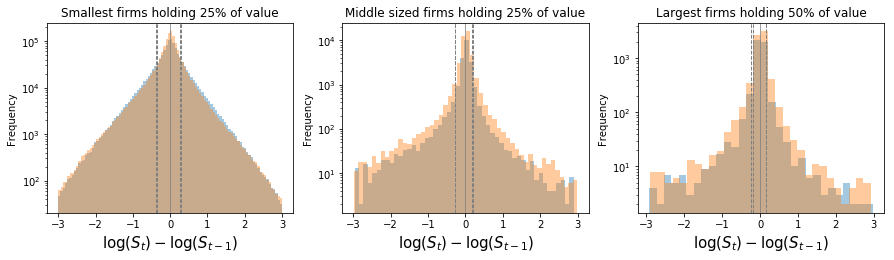

In [18]:
# n = 3
fig, axs = plt.subplots(1, 3, figsize = (5*3, 3.5))

cut = 3

for j, label in enumerate(['Exports', 'Imports']):
    sales = [Xy, My][j]
    parts_demo = [parts_demo_x, parts_demo_m][j]
    difflogsales = [logdiffXy, logdiffMy][j]
    
    # Exports
    for i in range(3):
        size_mask = [parts_demo == 0, parts_demo == 1, parts_demo.isin([2, 3])][i]
        hist_bins = [100, 50, 30][i]
        ax = axs[i]
        ax.set_title(['Smallest firms holding 25% of value', 'Middle sized firms holding 25% of value', 'Largest firms holding 50% of value'][i])
    #     log_rates = logsales.diff(axis = 1).stack()
        log_rates = difflogsales.loc[size_mask].stack()
        ax.hist(log_rates.loc[abs(log_rates) < cut], bins = hist_bins, alpha = .4)
        # wb_curve = ax.hist(log_rates.loc[abs(log_rates) < cut], bins = 150, alpha = .5)[0]
        ax.set_yscale('log')
        
        
        ### Measure of half nominal growth / Shrinkage.
        df_demlog_nominal = pd.concat([difflogsales.loc[size_mask].stack(), sales.diff(axis = 1).loc[size_mask].stack()], axis = 1)
        df_demlog_nominal.columns = ['demlog', 'gap']

        df_demlog_nominal = df_demlog_nominal.sort_values('demlog')
        df_demlog_nominal_growth = df_demlog_nominal.loc[df_demlog_nominal.gap > 0]
        df_demlog_nominal_shrink = df_demlog_nominal.loc[df_demlog_nominal.gap <= 0]
        half_nominal_measure_r = df_demlog_nominal_growth.loc[df_demlog_nominal_growth['gap'].cumsum()/df_demlog_nominal_growth['gap'].sum() < .5].demlog.max()
        half_nominal_measure_l = df_demlog_nominal_shrink.loc[df_demlog_nominal_shrink['gap'].cumsum()/df_demlog_nominal_shrink['gap'].sum() < .5].demlog.max()

        ax.axvline(half_nominal_measure_r, c = '.5', linestyle = '--', lw = 1)
        ax.axvline(half_nominal_measure_l, c = '.5', linestyle = '--', lw = 1) # factor of four... justification needs to be revised...
        ax.axvline(0, c = '.5', lw = .5)
        ax.set_xlabel(r'$\log(S_{t}) - \log(S_{t - 1})$', fontsize = 15)
        ax.set_ylabel('Frequency')
        
        
plt.savefig('./../../../WRITING/FIGURES/trade/gr_dist_Y.png', bbox_inches = "tight")


In [71]:
# half_nominal_measure_l = df_demlog_nominal_shrink.loc[df_demlog_nominal_shrink['gap'].cumsum()/df_demlog_nominal_shrink['gap'].sum() < .25].demlog.max()
# half_nominal_measure_r = df_demlog_nominal_growth.loc[df_demlog_nominal_growth['gap'].cumsum()/df_demlog_nominal_growth['gap'].sum() < .75].demlog.max()

# print(half_nominal_measure_r)
# print(half_nominal_measure_l)

# 0.31529652292441845
# -0.7318067184836652

0.31529652292441845
-0.7318067184836652


## Plots of log fluctuations

In [23]:
Q = 10

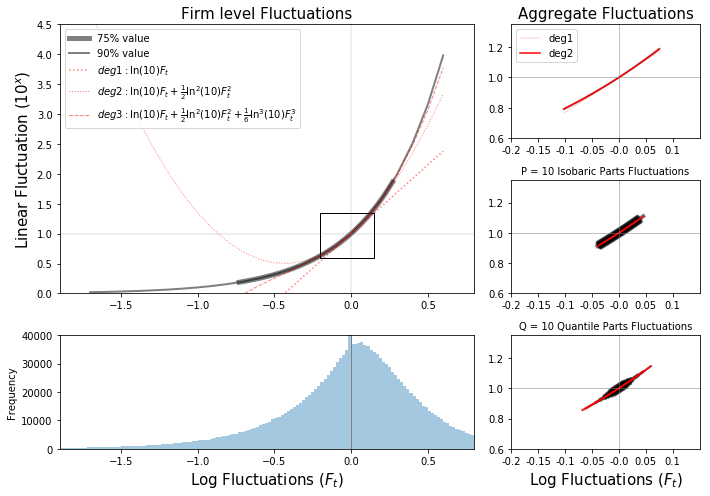

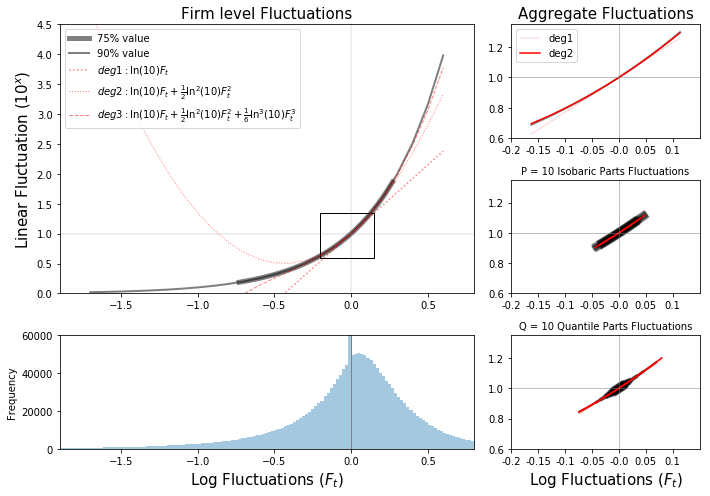

In [91]:
from matplotlib import gridspec
import matplotlib.patches as patches


for j, label in enumerate(['Exports', 'Imports']):
    sales = [X, M][j]
    
    # Compute info
    # Make Plots
    
    ###############################################
    ############# COMPUTE NEEDED INFO #############
    ###############################################

    # BS for sorted quantile partitions
    n = 20
    out = []

    for m in range(n):
        df_bs = sales.sample(frac = .5)
        df_bs = df_bs.loc[df_bs.sum(1).sort_values().index] #sorting
        df_bs['q'] = pd.cut(df_bs.sum(1).cumsum(), Q, labels = range(Q))

    #     nq = df_bs.groupby('q').count().mean(1) ## Effective nq
    #     nq = df_bs.q.value_counts()  ## Total count n

        df_bs = df_bs.groupby('q').sum()
        out += [df_bs]

    bs_data = pd.concat(out)

    demedianed_log10 = np.log10(bs_data/pd.concat(n*[bs_data.groupby(level = 0).median()]))
    qshocks = demedianed_log10.diff(axis = 1).stack().reset_index()
    qshocks['bin'] = pd.cut(qshocks[0], np.arange(-.1, .1, .001))


    # BS for sorted quantile partitions
    n = 20
    out = []

    for m in range(n):
        df_bs = sales.sample(frac = .5)
    #     df_bs = df_bs.loc[df_bs.sum(1).sort_values().index] #sorting
        df_bs['q'] = pd.cut(df_bs.sum(1).cumsum(), Q, labels = range(Q))
        df_bs = df_bs.groupby('q').sum()
        out += [df_bs]

    bs_data_unsort_q = pd.concat(out)

    demedianed_log10 = np.log10(bs_data_unsort_q/pd.concat(n*[bs_data_unsort_q.groupby(level = 0).median()]))
    qshocks2 = demedianed_log10.diff(axis = 1).stack().reset_index()
    qshocks2['bin'] = pd.cut(qshocks2[0], np.arange(-.1, .1, .001))



    ## BS for Aggregate
    n = 20
    lo_agg = []
    hi_agg = []
    for m in range(n):
        df_bs = sales.sample(frac = .5)
        df_bs.sum()

        agg = np.log10(df_bs.sum()/df_bs.sum().mean())

        lo_agg += [agg.quantile(.1)]
        hi_agg += [agg.quantile(.9)]

    lo_agg = np.array(lo_agg).mean()
    hi_agg = np.array(hi_agg).mean()

    ## Firm sales xlims come from other notebook
    
    
    ################################
    ############# PLOT #############
    ################################

    xl, xr = (-.2, .15)
    yl, yh = (.6, 1.35)
    xll, xrr = (-1.9, .8)

    fig = plt.figure(figsize = (10, 7))
    gs = gridspec.GridSpec(3, 3)

    ############################################################

    # ax1 micro exponential
    ax1 = plt.subplot(gs[:2, :2]); ax = ax1

    ### Firm level
    ax.set_title('Firm level Fluctuations', fontsize = 15)
    # half_nominal_measure_l = df_demlog_nominal_shrink.loc[df_demlog_nominal_shrink['gap'].cumsum()/df_demlog_nominal_shrink['gap'].sum() < .25].demlog.max()
    # half_nominal_measure_r = df_demlog_nominal_growth.loc[df_demlog_nominal_growth['gap'].cumsum()/df_demlog_nominal_growth['gap'].sum() < .75].demlog.max()

    x90 = np.arange(-1.7, 0.7, .1)
    x75 = np.arange(-.73, 0.32, .05)  # Only 25% of the value in added in shocks smaller than this, 25% of the value in added in shocks larger than this

    ax.plot(x75, np.power(10, x75), lw = 5, alpha = .5, color = 'k', label = '75% value')
    ax.plot(x90, np.power(10, x90), lw = 2, alpha = .5, color = 'k', label = '90% value')

    ax.plot(x90, 1 + np.log(10)*x90, linestyle = ':', alpha = .5, c = 'r', label = r'$deg 1: \ln(10) F_t$')
    ax.plot(x90, 1 + np.log(10)*x90 + (np.log(10)*x90)**2/2, linestyle = ':', alpha = .5, c = 'r', lw =1, label = r'$deg 2: \ln(10) F_t + \frac{1}{2}\ln^2(10) F^2_t $')
    ax.plot(x90, 1 + np.log(10)*x90 + (np.log(10)*x90)**2/2 + (np.log(10)*x90)**3/6, linestyle = '--', alpha = .5, c = 'r', lw =1, label = r'$deg3: \ln(10) F_t + \frac{1}{2}\ln^2(10) F^2_t +  \frac{1}{6}\ln^3(10) F^3_t$')


    # Create a Rectangle patch
    rect = patches.Rectangle((xl, yl), xr - xl, yh - yl,linewidth=1,edgecolor='k',facecolor='none')
    ax.add_patch(rect)

    ax.legend(loc = 'upper left')
    ax.set_ylim(0, 4.5)
    ax.set_ylabel(r'Linear Fluctuation ($10^x$)', fontsize = 15)

    ax.set_xlim(xll, xrr)

    ### Sorted quantile partition
    lo_q = qshocks.groupby('q')[0].quantile(.1)
    hi_q = qshocks.groupby('q')[0].quantile(.9)

    # Zero point guides
    ax.axvline(0, c = '.5', lw = .25)
    ax.axhline(1, c = '.5', lw = .25)
    
    ############################################################
    # ax2 micro gr dist
    ax2 = plt.subplot(gs[2, :2]); ax = ax2

    cut = 3

    demlogsales = [demlogX, demlogM][j]
    log_rates = demlogsales.stack()
    ax.hist(log_rates.loc[abs(log_rates) < cut], bins = np.arange(-cut, cut, 0.02), alpha = .4, normed=False)
    ax.set_ylim(0, [40000, 60000][j])
    ax.set_xlim(xll, xrr)

    ax.axvline(0, c = '.5', lw = 1)
    ax.set_xlabel(r'Log Fluctuations ($F_t$)', fontsize = 15)
    ax.set_ylabel('Frequency')

    ############################################################
    # ax3 agg exponential
    ax3 = plt.subplot(gs[0, 2]); ax = ax3

    ax.set_title('Aggregate Fluctuations', fontsize = 15)
    x = np.arange(lo_agg, hi_agg, 0.001)
    y = np.power(10, x)
    ax.plot(x, y, label = '', lw = 2, alpha = .5, color = 'k')
    ax.plot(x, np.log(10) * (x) + 1, c = 'r', linestyle = '--', lw = .25, label = 'deg1')
    ax.plot(x, (np.log(10) * (x))**2/2 + np.log(10) * (x) + 1, c = 'r', label = 'deg2')
    ax.set_xlim(xl, xr)
    ax.set_xticks(np.arange(xl, xr, .05))
    # ax.set_xticklabels(np.round(ax.get_xticks(), 3), rotation=45, ha = 'right')
    ax.set_xticklabels(np.round(ax.get_xticks(), 3))#, rotation=45, ha = 'right')
    ax.set_ylim(yl, yh)
    ax.legend()
    # ax.set_ylabel('Multiplicative Fluctuation (exp(x))')
    # Zero point guides
    ax.axvline(0, c = '.5', lw = .5)
    ax.axhline(1, c = '.5', lw = .5)
    ############################################################


    # ax5 quantile parts exponential
    ax5 = plt.subplot(gs[2, 2]); ax = ax5

    ax.set_title('Q = 10 Quantile Parts Fluctuations', fontsize = 10)
    for q in range(Q):
        x = np.arange(lo_q[q], hi_q[q], 0.001)
        y = np.power(10, x)
        ax.plot(x, y, label = q, lw = 10 - q, alpha = .5, color = 'k')
        ax.plot(x, np.log(10) * (x) + 1, c = 'r', linestyle = '--', lw = .25)
        ax.plot(x, (np.log(10) * x)**2/2 + np.log(10) * x + 1, c = 'r')

    ax.set_xlim(xl, xr)
    ax.set_xticks(np.arange(xl, xr, .05))
    # ax.set_xticklabels(np.round(ax.get_xticks(), 3), rotation=45, ha = 'right')
    ax.set_xticklabels(np.round(ax.get_xticks(), 3))#, rotation=45, ha = 'right')
    ax.set_ylim(yl, yh)
    # ax.legend(title = 'Part Q')
    # ax.set_ylabel('Multiplicative Fluctuation (exp(x))')
    ax.set_xlabel(r'Log Fluctuations ($F_t$)', fontsize = 15)
    # Zero point guides
    ax.axvline(0, c = '.5', lw = .5)
    ax.axhline(1, c = '.5', lw = .5)

    ############################################################

    # ax4 random parts exponential
    ax4 = plt.subplot(gs[1, 2]); ax = ax4

    lo_q = qshocks2.groupby('q')[0].quantile(.1)
    hi_q = qshocks2.groupby('q')[0].quantile(.9)

    # ax = axs[1][1]
    ax.set_title('P = 10 Isobaric Parts Fluctuations', fontsize = 10)
    for q in range(Q):
        x = np.arange(lo_q[q], hi_q[q], 0.001)
        y = np.power(10, x)
        ax.plot(x, y, label = q, lw = 10 - q, alpha = .5, color = 'k')
        ax.plot(x, np.log(10) * (x) + 1, c = 'r', linestyle = '--', lw = .25)
        ax.plot(x, (np.log(10) * x)**2/2 + np.log(10) * x + 1, c = 'r')
    ax.set_xlim(xl, xr)
    ax.set_xticks(np.arange(xl, xr, .05))
    # ax.set_xticklabels(np.round(ax.get_xticks(), 3), rotation=45, ha = 'right')
    ax.set_xticklabels(np.round(ax.get_xticks(), 3))#, rotation=45, ha = 'right')
    ax.set_ylim(yl, yh)
    # Zero point guides
    ax.axvline(0, c = '.5', lw = .5)
    ax.axhline(1, c = '.5', lw = .5)
    # ax.legend(title = 'Part P', loc = (1.1, 0))
    # ax.set_xlabel('Log Fluctuation')


    ############################################################
    plt.tight_layout()
    plt.savefig('./../../../WRITING/FIGURES/trade/series_approx_'+['X', 'M'][j]+'.png')
    plt.show()

In [ ]:
xx

### Separated by how many years they are present.

In [142]:
col = 'ID'
df = pd.read_csv(data_path + col.replace(' ', '_')+'_Y.csv')

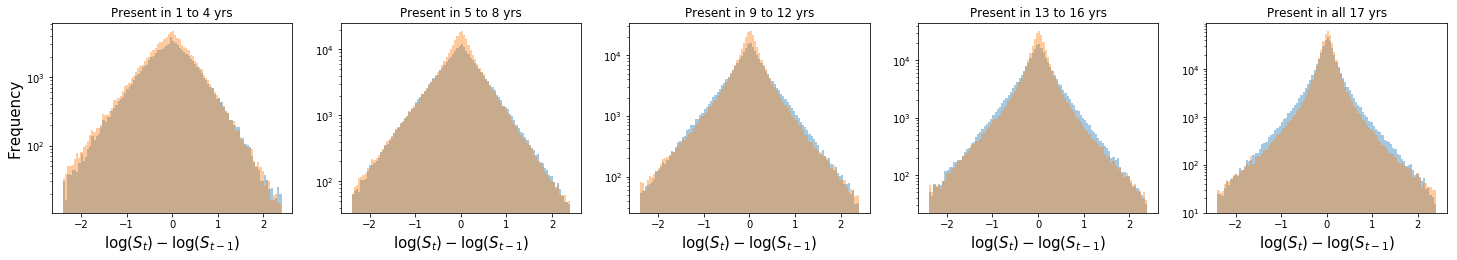

In [143]:
yrsbin = 4
n = int(np.ceil(17/yrsbin))
fig, axs = plt.subplots(1, n, figsize = (5*n, 3.5))
cut = 2.4

#### EXPORTS
sales = df.loc[df.IMPORT == 0].groupby(['ID', 'YEAR'])['VART'].sum().unstack()
### LOG10 vs LN for the horizontal scale
logsales = np.log10(sales)
# logsales = np.log(cuadro) # LN
demlogsales = logsales.subtract(logsales.mean(1), axis = 0)

for i in range(n):
    ax = axs[i]
    ax.set_title('Present in '+str(yrsbin*i + 1)+' to '+str(yrsbin*i + yrsbin)+' yrs')
    if i == n - 1: ax.set_title('Present in all 17 yrs')
    log_rates = logsales.loc[logsales.count(1)//yrsbin == i].diff(axis = 1).stack()
    ax.hist(log_rates.loc[abs(log_rates) < cut], bins = 100, alpha = .4)
    # wb_curve = ax.hist(log_rates.loc[abs(log_rates) < cut], bins = 150, alpha = .5)[0]
    ax.set_xlabel(r'$\log(S_{t}) - \log(S_{t - 1})$', fontsize = 15)
    if i == 0: ax.set_ylabel('Frequency', fontsize = 15)
    ax.set_yscale('log')


#### IMPORTS
sales = df.loc[df.IMPORT == 1].groupby(['ID', 'YEAR'])['VART'].sum().unstack()
### LOG10 vs LN for the horizontal scale
logsales = np.log10(sales)
# logsales = np.log(cuadro) # LN
demlogsales = logsales.subtract(logsales.mean(1), axis = 0)

for i in range(n):
    ax = axs[i]
    ax.set_title('Present in '+str(yrsbin*i + 1)+' to '+str(yrsbin*i + yrsbin)+' yrs')
    if i == n - 1: ax.set_title('Present in all 17 yrs')
    log_rates = logsales.loc[logsales.count(1)//yrsbin == i].diff(axis = 1).stack()
    ax.hist(log_rates.loc[abs(log_rates) < cut], bins = 100, alpha = .4)
    # wb_curve = ax.hist(log_rates.loc[abs(log_rates) < cut], bins = 150, alpha = .5)[0]
    ax.set_xlabel(r'$\log(S_{t}) - \log(S_{t - 1})$', fontsize = 15)
    if i == 0: ax.set_ylabel('Frequency', fontsize = 15)
    ax.set_yscale('log')

plt.savefig('./../../../WRITING/FIGURES/trade/gr_dist_yrspresent.png')

plt.show()

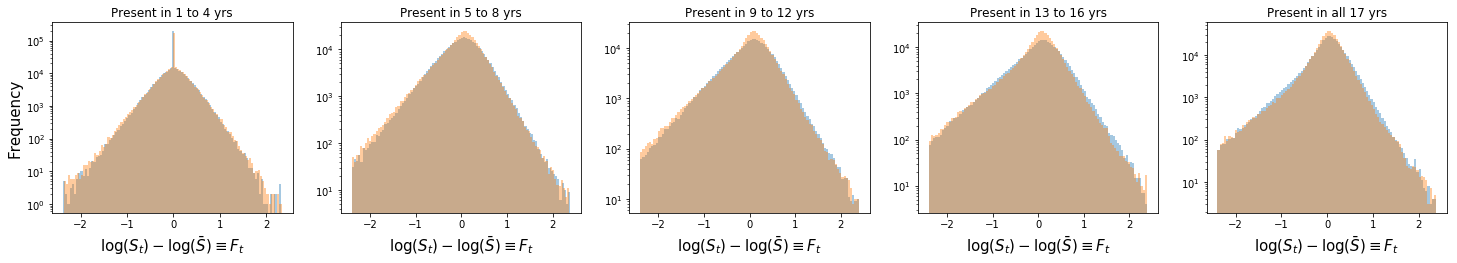

In [144]:
yrsbin = 4
n = int(np.ceil(17/yrsbin))
fig, axs = plt.subplots(1, n, figsize = (5*n, 3.5))
cut = 2.4


#### EXPORTS
sales = df.loc[df.IMPORT == 0].groupby(['ID', 'YEAR'])['VART'].sum().unstack()
### LOG10 vs LN for the horizontal scale
logsales = np.log10(sales)
# logsales = np.log(cuadro) # LN
demlogsales = logsales.subtract(logsales.mean(1), axis = 0)


for i in range(n):
    ax = axs[i]
    ax.set_title('Present in '+str(yrsbin*i + 1)+' to '+str(yrsbin*i + yrsbin)+' yrs')
    if i == n - 1: ax.set_title('Present in all 17 yrs')
    log_shocks = demlogsales.loc[demlogsales.count(1)//yrsbin == i].stack()
    ax.hist(log_shocks.loc[abs(log_shocks) < cut], bins = 100, alpha = .4)
    # wb_curve = ax.hist(log_rates.loc[abs(log_rates) < cut], bins = 150, alpha = .5)[0]
    ax.set_xlabel(r'$\log(S_{t}) - \log(\bar S) \equiv F_t$', fontsize = 15)
    if i == 0: ax.set_ylabel('Frequency', fontsize = 15)
    ax.set_yscale('log')


#### IMPORTS
sales = df.loc[df.IMPORT == 1].groupby(['ID', 'YEAR'])['VART'].sum().unstack()
### LOG10 vs LN for the horizontal scale
logsales = np.log10(sales)
# logsales = np.log(cuadro) # LN
demlogsales = logsales.subtract(logsales.mean(1), axis = 0)

for i in range(n):
    ax = axs[i]
    ax.set_title('Present in '+str(yrsbin*i + 1)+' to '+str(yrsbin*i + yrsbin)+' yrs')
    if i == n - 1: ax.set_title('Present in all 17 yrs')
    log_shocks = demlogsales.loc[demlogsales.count(1)//yrsbin == i].stack()
    ax.hist(log_shocks.loc[abs(log_shocks) < cut], bins = 100, alpha = .4)
    # wb_curve = ax.hist(log_rates.loc[abs(log_rates) < cut], bins = 150, alpha = .5)[0]
    ax.set_xlabel(r'$\log(S_{t}) - \log(\bar S) \equiv F_t$', fontsize = 15)
    if i == 0: ax.set_ylabel('Frequency', fontsize = 15)
    ax.set_yscale('log')

plt.savefig('./../../../WRITING/FIGURES/trade/fl_dist_yrspresent.png')

plt.show()

In [145]:
# # Se podria estimar una recta para cada row con lo siguiente. Unfortunaltely fillna not implemented for row means, so cannot get beta like this with even only a single nan.
# # Se usa double traspose

# # logsales_fillna = (np.log10(sales).T.fillna(np.log10(sales).mean(1))).T
# betas = logsales_fillna.apply(lambda x: np.cov(years_x, x)[0, 1]/years_x.var() * (16/17), axis = 1)

In [146]:
sales = df.loc[df.IMPORT == 0].groupby(['ID', 'YEAR'])['VART'].sum().unstack()
### LOG10 vs LN for the horizontal scale
logsales = np.log10(sales)
# logsales = np.log(cuadro) # LN
demlogsales = logsales.subtract(logsales.mean(1), axis = 0)

In [147]:
# Well bahaved masks
# We want that roughly half of the time series is above and half below the mean, but also avoid line like balance, where all points above are on the same side of the TS (like there is a line tencency.)
# Also ask that there are values in at least 5 years
presence_mask = demlogsales.count(1) > 4
balance_0_mask = abs(np.sign(demlogsales).sum(1)) < 4
balance_1_mask = abs(np.sign(demlogsales).iloc[:, :int(len(demlogsales.columns)/2)].sum(1) - np.sign(demlogsales).iloc[:, -int(len(demlogsales.columns)/2):].sum(1)) < 7

# WB_mask = (presence_mask*balance_0_mask*balance_1_mask)
WB_mask = (balance_0_mask*balance_1_mask)

# Porcentaje de las ventas incluidas en "well behaved"
sales.loc[WB_mask].sum()/sales.sum()

YEAR
1997    0.323262
1998    0.312610
1999    0.292383
2000    0.269214
2001    0.253497
2002    0.247883
2003    0.231968
2004    0.230072
2005    0.237871
2006    0.232595
2007    0.224441
2008    0.223297
2009    0.228359
2010    0.262100
2011    0.275575
2012    0.295379
2013    0.317967
dtype: float64

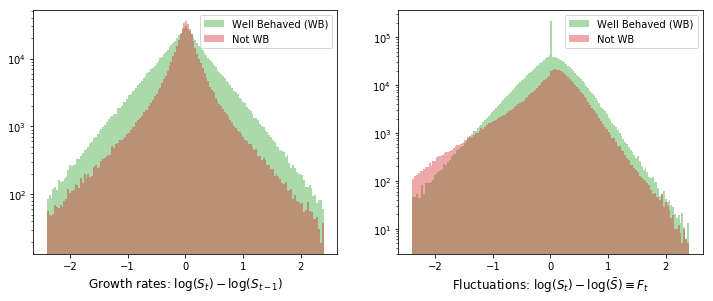

In [154]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4.5))

cut = 2.4

ax = axs[0]
log_rates = logsales.loc[WB_mask].diff(axis = 1).stack()
ax.hist(log_rates.loc[abs(log_rates) < cut], bins = 150, alpha = .4, color = '#2ca02c')
# wb_curve = ax.hist(log_rates.loc[abs(log_rates) < cut], bins = 150, alpha = .5)[0]

log_rates = logsales.loc[~WB_mask].diff(axis = 1).stack()
ax.hist(log_rates.loc[abs(log_rates) < cut], bins = 150, alpha = .4, color = '#d62728')
# other_curve = ax.hist(log_rates.loc[abs(log_rates) < cut], bins = 150, alpha = .5)[0]
ax.legend(['Well Behaved (WB)', 'Not WB'])
ax.set_xlabel('Growth rates: '+r'$\log(S_{t}) - \log(S_{t - 1})$', fontsize = 12)
ax.set_yscale('log')


ax = axs[1]
log_shocks = demlogsales.loc[WB_mask].stack()
ax.hist(log_shocks.loc[abs(log_shocks) < cut], bins = 150, alpha = .4, color = '#2ca02c')

log_shocks = demlogsales.loc[~WB_mask].stack()
ax.hist(log_shocks.loc[abs(log_shocks) < cut], bins = 150, alpha = .4, color = '#d62728')
ax.legend(['Well Behaved (WB)', 'Not WB'])
ax.set_yscale('log')
ax.set_xlabel('Fluctuations: '+r'$\log(S_{t}) - \log(\bar S) \equiv F_t$', fontsize = 12)

plt.savefig('./../../../WRITING/FIGURES/trade/wbcond_gr_fl.png')
    
plt.show()

In [149]:
# ##3 Other experiments

# fig, ax = plt.subplots(1, figsize = (12, 8))
# ax.plot(np.log10(other_curve) - np.log10(wb_curve), marker = '.', lw = 0)
# plt.yscale('log')


# fig, axs = plt.subplots(1, 2, figsize = (24, 8))
# logsales.loc[(~WB_mask) & (logsales.count(1) == 17)].sample(5).T.plot(legend  =False, ax = axs[0])
# logsales.loc[WB_mask].sample(5).T.plot(legend  =False, ax = axs[1], marker = '.')
# plt.show()

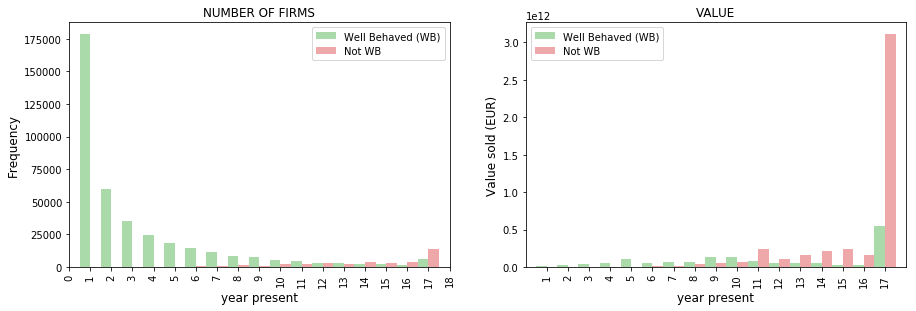

In [155]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4.5))


ax = axs[0]
ax.set_title('NUMBER OF FIRMS')
data1 = pd.DataFrame(np.histogram(logsales.loc[WB_mask].count(1).values, bins = range(20))).T
data2 = pd.DataFrame(np.histogram(logsales.loc[~WB_mask].count(1).values, bins = range(20))).T
data1.index = data1[1].astype(int)
data2.index = data2[1].astype(int)
data = pd.concat([data1[0], data2[0]], axis = 1)
data.plot(kind = 'bar', color = ['#2ca02c', '#d62728'], alpha = .4, ax = ax, width=1)
ax.set_xlabel('year present', fontsize = 12)
ax.set_ylabel('Frequency', fontsize = 12)
ax.legend(['Well Behaved (WB)', 'Not WB'])
ax.set_xlim(0, 18)
# ax.set_xticks(axs[1].get_xticks())
# ax.set_xticklabels(axs[1].get_xticklabels())

ax = axs[1]
ax.set_title('VALUE')
data1 = sales.loc[WB_mask].groupby(sales.loc[WB_mask].count(1)).sum().sum(1)
data2 = sales.loc[~WB_mask].groupby(sales.loc[~WB_mask].count(1)).sum().sum(1)
data = pd.concat([data1, data2], axis = 1)
data.plot(kind = 'bar', color = ['#2ca02c', '#d62728'], alpha = .4, ax = ax, width=1)
ax.set_xlabel('year present', fontsize = 12)
ax.set_ylabel('Value sold (EUR)', fontsize = 12)
ax.legend(['Well Behaved (WB)', 'Not WB'])
ax.set_xlim(-1, 17)


plt.savefig('./../../../WRITING/FIGURES/trade/wbcond_cnt_val_yrspresent.png')

plt.show()

In [ ]:
xx

In [149]:
# (np.sign(demlogsales).iloc[:, :int(len(demlogsales.columns)/2)].sum(1) - np.sign(demlogsales).iloc[:, -int(len(demlogsales.columns)/2):].sum(1)).hist(bins = np.arange(-16, 16, 1))
# np.sign(demlogsales).iloc[:, :int(len(demlogsales.columns)/2)].sum(1).min()
# np.sign(demlogsales).iloc[:, -int(len(demlogsales.columns)/2):].sum(1)

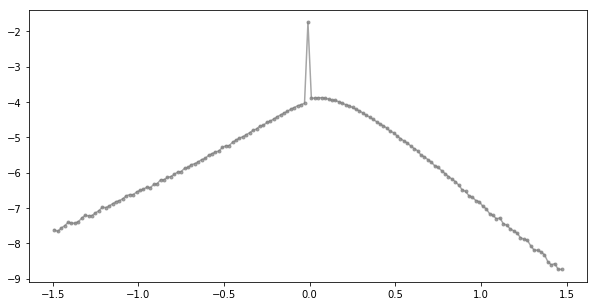

In [40]:
# demeaned.sample(10).T.plot(legend = False)
logshocks = demlogsales.loc[~WB_mask].stack()

logshocks.describe()

logshockbin = pd.cut(logshocks, np.arange(-1.5, 1.5, .02))
# logshockbin = pd.cut(logshocks, np.arange(-4, 4, .05)) #ln scale

counts = logshocks.groupby(logshockbin).count()

x = np.array([b.mid for b in counts.index])
y = np.log(counts/len(logshocks)).values

counts_df = pd.DataFrame([x, y]).T.replace(-np.inf, np.nan).dropna()
counts_df.columns = ['g_rate', 'ln_PDF']

# Make a copy where only fat tail values are kept
counts_df_FT = counts_df.copy()
counts_df_FT['ln_PDF'] = counts_df_FT['ln_PDF'].clip(-np.inf, -2.2).replace(-2.2, np.nan)
fit_data = counts_df_FT.dropna()
ydata = fit_data.ln_PDF.values
xdata = fit_data.g_rate.values

fig, ax = plt.subplots(1, figsize = (10, 5))
data, = ax.plot(counts_df.g_rate, counts_df.ln_PDF, 'b-', marker = '.', c = '.5', alpha = .7)


 
-3.422 x - 3.209


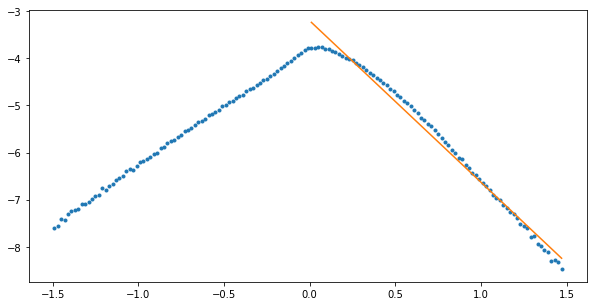

In [154]:
xp = xdata[:int(len(xdata)/2)]
yp = ydata[:int(len(xdata)/2)]
z = np.polyfit(xp, yp, 1)
b = z[0]/np.log(10)

# xp = xdata[-int(len(xdata)/2) + 10:]
# yp = ydata[-int(len(xdata)/2) + 10:]
xp = xdata[-int(len(xdata)/2):]
yp = ydata[-int(len(xdata)/2):]
z = np.polyfit(xp, yp, 1)
a = -z[0]/np.log(10)

data, = ax.plot(counts_df.g_rate, counts_df.ln_PDF, 'b-', marker = '.', c = '.5', alpha = .7)
p = np.poly1d(z)
print(p)
fig, ax = plt.subplots(1, figsize = (10, 5))
ax.plot(x, y, '.', xp, p(xp), '-')
plt.show()

In [155]:
a*b

1.6208005053239243

In [156]:
(a-1)*(b+1)

1.016131252959416

In [157]:
#Mean
m = a*b/(a-1)/(b+1)
print(m)

#variance
s2 = a*b/(a-2)/(b+2) - (a*b/(a-1)/(b+1))**2
print(s2)
print(np.sqrt(-s2))

 # Tengo alguna duda con el hecho que el eje horizontal esta escalado por ln(10), o bien, que la definicion de mi Laplace no es exp(L) sino 10**L
    
# median
med = ((a + b)/(2*a))**(1/b)
print(med)

1.5950700272267473
-3.5645579505658738
1.888003694531839
0.8773353046976333


1.6938773394165925
-3.864395083485841
1.9658064715240513
0.9077554566722923


In [46]:
np.log10(m - np.sqrt(s2))
np.log10(m + np.sqrt(s2))

0.19267122607161064

In [52]:
(10**logshocks).var()

69.15361349294623

In [53]:
(10**logshocks).median()

1.0552214640926816

In [4]:
# # df_level_g_list = []
# for i in [0, 1]:   
# #     df_level_g = df_level_g_list[i]
#     df_level_g = pd.read_csv('./../../data/processed/logdiff_annual_'+str(i)+'.csv')

#     df_level_g['annual_log_bin'] = pd.cut(df_level_g['annual_log'], np.arange(4, 10, .5))